In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import keras
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.utils import shuffle

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 把所有年份的資料merge在一起,並存在data.csv裡
def mergeData():
    SaveFile_Name = 'data.csv'
    file_list = os.listdir('data')
    df = pd.read_csv('data'+'\\'+file_list[0])
    df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False)
    for i in range(1,len(file_list)):
        df = pd.read_csv('data'+'\\'+file_list[i])
        df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False, header=False, mode='a+')

In [3]:
# 讀取data.csv
def readData():
    train = pd.read_csv("data.csv")
    return train

In [4]:
# 把年份換成西元年
def changeYear(data):
    for i in range(0,data.shape[0]):
        Date=data["日期"][i].split('/')
        year,month,date=Date[0],Date[1],Date[2]
        year=str(int(year)+1911)
        data.loc[i,"日期"]=year+'/'+month+'/'+date
    return data

In [5]:
# 增加features("年","月","日","第幾日")
def augFeatures(data):
  data["日期"] = pd.to_datetime(data["日期"])
  data["年"] = data["日期"].dt.year
  data["月"] = data["日期"].dt.month
  data["日"] = data["日期"].dt.day
  data["第幾日"] = data["日期"].dt.dayofweek
  return data

In [6]:
# 把非數字的資料換成正確資料,並減少features("日期","成交股數","成交金額",等等...)
def manage(data):
    for i in range(0,data.shape[0]):
        if data["漲跌價差"][i]=='X0.00':
            data.loc[i,"漲跌價差"]=str(int(data["收盤價"][i])-int(data["收盤價"][i-1]))
    data=data.drop(["日期"], axis=1)
    data=data.drop(["成交股數"], axis=1)
    data=data.drop(["成交金額"], axis=1)
    data=data.drop(["漲跌價差"], axis=1)
    data=data.drop(["成交筆數"], axis=1)
    data=data.convert_objects(convert_numeric=True)
    return data

In [7]:
# 把資料normalize
def normalize(train):
    train = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train

In [8]:
# 創造出train的資料,train_x為輸入資料(所有features),train_y為輸出資料(開盤價的成長率,分為9個區段)
def buildTrain(train, pastDay=30, futureDay=1):
    X_train, Y_train, Z_train= [], [], []
    X,Y,Z=[],[],[]
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["開盤價"]))
        Z_train.append(np.array(train.iloc[i+pastDay-1:i+pastDay]["開盤價"]))
    X=np.array(X_train)
    Y=np.array(Y_train)
    Z=np.array(Z_train)
    Y=100*((Y-Z)/Z)
    Y_train=[]
    
    for i in range(len(Y)):
        if Y[i]<-3.5:
            Y_train.append(np.array([0]))
        elif -3.5<=Y[i]<-2.5:
            Y_train.append(np.array([1]))
        elif -2.5<=Y[i]<-1.5:
            Y_train.append(np.array([2]))
        elif -1.5<=Y[i]<-0.5:
            Y_train.append(np.array([3]))
        elif -0.5<=Y[i]<0.5:
            Y_train.append(np.array([4]))
        elif 0.5<=Y[i]<1.5:
            Y_train.append(np.array([5]))
        elif 1.5<=Y[i]<2.5:
            Y_train.append(np.array([6]))
        elif 2.5<=Y[i]<3.5:
            Y_train.append(np.array([7]))
        elif 3.5<=Y[i]:
            Y_train.append(np.array([8]))
    Y=np.array(Y_train)
    
    return X, Y

In [9]:
# 把資料打亂
def shuffle(X,Y):
    np.random.seed()
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

In [10]:
# 將資料分成訓練資料和測試資料
def splitData(X,Y,rate):
    X_train = X[:-int(X.shape[0]*rate)]

    Y_train = Y[:-int(Y.shape[0]*rate)]
    
    X_val = X[-int(X.shape[0]*rate):]

    Y_val = Y[-int(Y.shape[0]*rate):]
    return X_train, Y_train, X_val, Y_val

In [11]:
# 建立模型
def buildModel(shape):
    model = Sequential()
    model.add(Dense(250, input_dim=shape[1]))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(250))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(9))
    model.add(Activation('softmax'))
    model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [12]:
# 印出loss, accuracy,val_loss, val_accuracy
class History(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
 
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
 
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
 
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()


In [13]:
mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
train=train.drop(["最高價"], axis=1)
train=train.drop(["最低價"], axis=1)
train=train.drop(["收盤價"], axis=1)
train=train.drop(["年"], axis=1)
train=train.drop(["月"], axis=1)
train=train.drop(["日"], axis=1)
train=train.drop(["第幾日"], axis=1)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,1,1)
train_x2, train_y2 = buildTrain(temp,1,1)
train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = History()
model = buildModel(train_x.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[callback,history])


C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 250)               500       
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               62750     
_________________________________________________________________
activation_2 (Activation)    (None, 250)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 2259      
__________

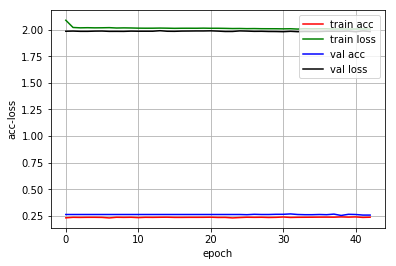

618/618 [==============================] - 0s 26us/step
test loss:  2.0252510737446907
test accuracy:  0.2200647249673177


In [14]:
history.loss_plot('epoch')
loss_1, accuracy_1 = model.evaluate(test_x, test_y)
print('test loss: ', loss_1)
print('test accuracy: ', accuracy_1)

In [15]:
mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
train=train.drop(["最高價"], axis=1)
train=train.drop(["最低價"], axis=1)
train=train.drop(["收盤價"], axis=1)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,1,1)
train_x2, train_y2 = buildTrain(temp,1,1)
train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = History()
model = buildModel(train_x.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[callback,history])

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 250)               1500      
_________________________________________________________________
activation_4 (Activation)    (None, 250)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               62750     
_________________________________________________________________
activation_5 (Activation)    (None, 250)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 2259      
__________

Epoch 81/300
 - 0s - loss: 1.8617 - acc: 0.2986 - val_loss: 2.0134 - val_acc: 0.2151
Epoch 82/300
 - 0s - loss: 1.8623 - acc: 0.2857 - val_loss: 2.0134 - val_acc: 0.2204
Epoch 83/300
 - 0s - loss: 1.8642 - acc: 0.2930 - val_loss: 2.0067 - val_acc: 0.2240
Epoch 84/300
 - 0s - loss: 1.8635 - acc: 0.2940 - val_loss: 2.0087 - val_acc: 0.2312
Epoch 85/300
 - 0s - loss: 1.8603 - acc: 0.2946 - val_loss: 2.0156 - val_acc: 0.2258
Epoch 86/300
 - 0s - loss: 1.8576 - acc: 0.2906 - val_loss: 2.0199 - val_acc: 0.2276
Epoch 87/300
 - 0s - loss: 1.8630 - acc: 0.2970 - val_loss: 2.0164 - val_acc: 0.2168
Epoch 88/300
 - 0s - loss: 1.8581 - acc: 0.2932 - val_loss: 2.0183 - val_acc: 0.2294
Epoch 89/300
 - 0s - loss: 1.8573 - acc: 0.2934 - val_loss: 2.0203 - val_acc: 0.2151
Epoch 90/300
 - 0s - loss: 1.8529 - acc: 0.2936 - val_loss: 2.0255 - val_acc: 0.2133
Epoch 91/300
 - 0s - loss: 1.8498 - acc: 0.3004 - val_loss: 2.0194 - val_acc: 0.2133
Epoch 92/300
 - 0s - loss: 1.8559 - acc: 0.2863 - val_loss: 2.019

Epoch 177/300
 - 0s - loss: 1.7771 - acc: 0.3154 - val_loss: 2.0491 - val_acc: 0.2186
Epoch 178/300
 - 0s - loss: 1.7763 - acc: 0.3264 - val_loss: 2.0580 - val_acc: 0.2276
Epoch 179/300
 - 0s - loss: 1.7812 - acc: 0.3238 - val_loss: 2.0592 - val_acc: 0.2258
Epoch 180/300
 - 0s - loss: 1.7719 - acc: 0.3170 - val_loss: 2.0566 - val_acc: 0.2276
Epoch 181/300
 - 0s - loss: 1.7681 - acc: 0.3268 - val_loss: 2.0536 - val_acc: 0.2348
Epoch 182/300
 - 0s - loss: 1.7713 - acc: 0.3289 - val_loss: 2.0506 - val_acc: 0.2330
Epoch 183/300
 - 0s - loss: 1.7706 - acc: 0.3269 - val_loss: 2.0646 - val_acc: 0.2312
Epoch 00183: early stopping


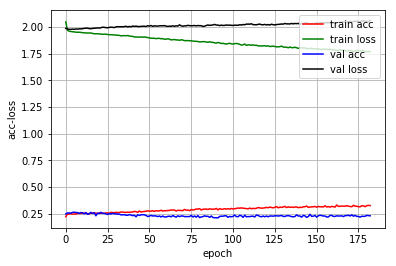

618/618 [==============================] - 0s 31us/step
test loss:  2.084410680536313
test accuracy:  0.20711974114854745


In [16]:
history.loss_plot('epoch')
loss_2, accuracy_2 = model.evaluate(test_x, test_y)
print('test loss: ', loss_2)
print('test accuracy: ', accuracy_2)

In [22]:
mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
train=train.drop(["收盤價"], axis=1)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,1,1)
train_x2, train_y2 = buildTrain(temp,1,1)
train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = History()
model = buildModel(train_x.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[callback,history])

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 250)               2000      
_________________________________________________________________
activation_13 (Activation)   (None, 250)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 250)               62750     
_________________________________________________________________
activation_14 (Activation)   (None, 250)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 9)                 2259      
__________

Epoch 81/300
 - 0s - loss: 1.8620 - acc: 0.2845 - val_loss: 1.9869 - val_acc: 0.1971
Epoch 82/300
 - 0s - loss: 1.8639 - acc: 0.2833 - val_loss: 1.9868 - val_acc: 0.2025
Epoch 83/300
 - 0s - loss: 1.8635 - acc: 0.2910 - val_loss: 1.9921 - val_acc: 0.1989
Epoch 84/300
 - 0s - loss: 1.8587 - acc: 0.2934 - val_loss: 1.9861 - val_acc: 0.1989
Epoch 85/300
 - 0s - loss: 1.8591 - acc: 0.2948 - val_loss: 1.9845 - val_acc: 0.2025
Epoch 86/300
 - 0s - loss: 1.8635 - acc: 0.2924 - val_loss: 1.9824 - val_acc: 0.2097
Epoch 87/300
 - 0s - loss: 1.8572 - acc: 0.2924 - val_loss: 1.9900 - val_acc: 0.2043
Epoch 88/300
 - 0s - loss: 1.8509 - acc: 0.2946 - val_loss: 1.9911 - val_acc: 0.2079
Epoch 89/300
 - 0s - loss: 1.8539 - acc: 0.2904 - val_loss: 1.9876 - val_acc: 0.2007
Epoch 90/300
 - 0s - loss: 1.8509 - acc: 0.2952 - val_loss: 1.9871 - val_acc: 0.2115
Epoch 91/300
 - 0s - loss: 1.8518 - acc: 0.3000 - val_loss: 1.9878 - val_acc: 0.2007
Epoch 92/300
 - 0s - loss: 1.8495 - acc: 0.2968 - val_loss: 1.986

Epoch 177/300
 - 0s - loss: 1.7691 - acc: 0.3325 - val_loss: 1.9868 - val_acc: 0.2240
Epoch 178/300
 - 0s - loss: 1.7741 - acc: 0.3329 - val_loss: 1.9949 - val_acc: 0.2133
Epoch 179/300
 - 0s - loss: 1.7665 - acc: 0.3313 - val_loss: 1.9916 - val_acc: 0.2168
Epoch 180/300
 - 0s - loss: 1.7723 - acc: 0.3299 - val_loss: 1.9829 - val_acc: 0.2258
Epoch 181/300
 - 0s - loss: 1.7700 - acc: 0.3256 - val_loss: 1.9911 - val_acc: 0.2222
Epoch 182/300
 - 0s - loss: 1.7650 - acc: 0.3295 - val_loss: 1.9856 - val_acc: 0.2204
Epoch 183/300
 - 0s - loss: 1.7596 - acc: 0.3262 - val_loss: 1.9828 - val_acc: 0.2133
Epoch 184/300
 - 0s - loss: 1.7714 - acc: 0.3220 - val_loss: 1.9919 - val_acc: 0.2204
Epoch 185/300
 - 0s - loss: 1.7672 - acc: 0.3339 - val_loss: 1.9979 - val_acc: 0.2186
Epoch 186/300
 - 0s - loss: 1.7626 - acc: 0.3264 - val_loss: 1.9888 - val_acc: 0.2312
Epoch 187/300
 - 0s - loss: 1.7669 - acc: 0.3295 - val_loss: 1.9829 - val_acc: 0.2204
Epoch 188/300
 - 0s - loss: 1.7580 - acc: 0.3331 - val

Epoch 273/300
 - 0s - loss: 1.6678 - acc: 0.3662 - val_loss: 1.9437 - val_acc: 0.2419
Epoch 274/300
 - 0s - loss: 1.6529 - acc: 0.3680 - val_loss: 1.9462 - val_acc: 0.2509
Epoch 275/300
 - 0s - loss: 1.6659 - acc: 0.3690 - val_loss: 1.9507 - val_acc: 0.2419
Epoch 276/300
 - 0s - loss: 1.6582 - acc: 0.3641 - val_loss: 1.9516 - val_acc: 0.2473
Epoch 277/300
 - 0s - loss: 1.6449 - acc: 0.3726 - val_loss: 1.9497 - val_acc: 0.2401
Epoch 278/300
 - 0s - loss: 1.6605 - acc: 0.3704 - val_loss: 1.9509 - val_acc: 0.2384
Epoch 279/300
 - 0s - loss: 1.6325 - acc: 0.3752 - val_loss: 1.9367 - val_acc: 0.2455
Epoch 280/300
 - 0s - loss: 1.6489 - acc: 0.3730 - val_loss: 1.9313 - val_acc: 0.2455
Epoch 281/300
 - 0s - loss: 1.6448 - acc: 0.3724 - val_loss: 1.9267 - val_acc: 0.2437
Epoch 282/300
 - 0s - loss: 1.6414 - acc: 0.3766 - val_loss: 1.9397 - val_acc: 0.2437
Epoch 283/300
 - 0s - loss: 1.6403 - acc: 0.3784 - val_loss: 1.9392 - val_acc: 0.2401
Epoch 284/300
 - 0s - loss: 1.6355 - acc: 0.3786 - val

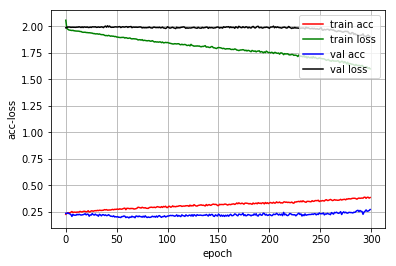

618/618 [==============================] - 0s 32us/step
test loss:  1.9343295714616004
test accuracy:  0.2588996765682998


In [23]:
history.loss_plot('epoch')
loss_3, accuracy_3 = model.evaluate(test_x, test_y)
print('test loss: ', loss_3)
print('test accuracy: ', accuracy_3)

In [24]:
mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,1,1)
train_x2, train_y2 = buildTrain(temp,1,1)
train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
print(train)
history = History()
model = buildModel(train_x.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[callback,history])


C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


           開盤價       最高價       最低價       收盤價         年         月         日  \
0    -0.021496 -0.026024 -0.017142 -0.021671 -0.499051  0.209821 -0.359942   
1     0.006401  0.001969  0.011417  0.006540 -0.499051  0.209821 -0.326609   
2     0.036444  0.032116  0.042173  0.036922 -0.499051  0.209821 -0.293275   
3     0.068632  0.064416  0.075126  0.069475 -0.499051  0.209821 -0.259942   
4     0.102967  0.098869  0.110275  0.104197 -0.499051  0.209821 -0.226609   
5     0.139448  0.135475  0.147621  0.141089 -0.499051  0.209821 -0.193275   
6     0.178074  0.174235  0.187164  0.180152 -0.499051  0.209821 -0.126609   
7     0.218847  0.215148  0.228904  0.221384 -0.499051  0.209821 -0.093275   
8     0.261765  0.258214  0.272841  0.264787 -0.499051  0.209821 -0.059942   
9     0.308976  0.305587  0.286022  0.312530 -0.499051  0.209821 -0.026609   
10    0.308976  0.322814  0.299203  0.303850 -0.499051  0.209821  0.006725   
11    0.300392  0.314200  0.303597  0.303850 -0.499051  0.209821

Epoch 12/300
 - 0s - loss: 1.9479 - acc: 0.2498 - val_loss: 1.9791 - val_acc: 0.2348
Epoch 13/300
 - 0s - loss: 1.9468 - acc: 0.2474 - val_loss: 1.9797 - val_acc: 0.2294
Epoch 14/300
 - 0s - loss: 1.9467 - acc: 0.2527 - val_loss: 1.9812 - val_acc: 0.2437
Epoch 15/300
 - 0s - loss: 1.9463 - acc: 0.2529 - val_loss: 1.9830 - val_acc: 0.2348
Epoch 16/300
 - 0s - loss: 1.9432 - acc: 0.2547 - val_loss: 1.9827 - val_acc: 0.2312
Epoch 17/300
 - 0s - loss: 1.9437 - acc: 0.2549 - val_loss: 1.9807 - val_acc: 0.2330
Epoch 18/300
 - 0s - loss: 1.9437 - acc: 0.2535 - val_loss: 1.9825 - val_acc: 0.2348
Epoch 19/300
 - 0s - loss: 1.9384 - acc: 0.2565 - val_loss: 1.9847 - val_acc: 0.2455
Epoch 20/300
 - 0s - loss: 1.9388 - acc: 0.2509 - val_loss: 1.9821 - val_acc: 0.2366
Epoch 21/300
 - 0s - loss: 1.9389 - acc: 0.2501 - val_loss: 1.9834 - val_acc: 0.2401
Epoch 22/300
 - 0s - loss: 1.9365 - acc: 0.2551 - val_loss: 1.9832 - val_acc: 0.2401
Epoch 23/300
 - 0s - loss: 1.9371 - acc: 0.2541 - val_loss: 1.982

Epoch 109/300
 - 0s - loss: 1.7023 - acc: 0.3361 - val_loss: 1.7837 - val_acc: 0.3082
Epoch 110/300
 - 0s - loss: 1.6942 - acc: 0.3449 - val_loss: 1.8001 - val_acc: 0.2939
Epoch 111/300
 - 0s - loss: 1.6863 - acc: 0.3465 - val_loss: 1.7623 - val_acc: 0.3244
Epoch 112/300
 - 0s - loss: 1.6732 - acc: 0.3563 - val_loss: 1.7672 - val_acc: 0.3297
Epoch 113/300
 - 0s - loss: 1.6937 - acc: 0.3497 - val_loss: 1.7712 - val_acc: 0.3190
Epoch 114/300
 - 0s - loss: 1.6637 - acc: 0.3591 - val_loss: 1.7457 - val_acc: 0.3315
Epoch 115/300
 - 0s - loss: 1.6556 - acc: 0.3509 - val_loss: 1.7383 - val_acc: 0.3190
Epoch 116/300
 - 0s - loss: 1.6556 - acc: 0.3517 - val_loss: 1.7221 - val_acc: 0.3333
Epoch 117/300
 - 0s - loss: 1.6457 - acc: 0.3563 - val_loss: 1.7507 - val_acc: 0.2993
Epoch 118/300
 - 0s - loss: 1.6489 - acc: 0.3597 - val_loss: 1.7279 - val_acc: 0.3244
Epoch 119/300
 - 0s - loss: 1.6418 - acc: 0.3686 - val_loss: 1.7304 - val_acc: 0.3405
Epoch 120/300
 - 0s - loss: 1.6390 - acc: 0.3601 - val

Epoch 205/300
 - 0s - loss: 1.4607 - acc: 0.4353 - val_loss: 1.6423 - val_acc: 0.3513
Epoch 206/300
 - 0s - loss: 1.4753 - acc: 0.4261 - val_loss: 1.6414 - val_acc: 0.3584
Epoch 207/300
 - 0s - loss: 1.4644 - acc: 0.4233 - val_loss: 1.6185 - val_acc: 0.3781
Epoch 208/300
 - 0s - loss: 1.4693 - acc: 0.4269 - val_loss: 1.5993 - val_acc: 0.3674
Epoch 209/300
 - 0s - loss: 1.4650 - acc: 0.4478 - val_loss: 1.6007 - val_acc: 0.3781
Epoch 210/300
 - 0s - loss: 1.4579 - acc: 0.4426 - val_loss: 1.6143 - val_acc: 0.3674
Epoch 211/300
 - 0s - loss: 1.4636 - acc: 0.4423 - val_loss: 1.6067 - val_acc: 0.3638
Epoch 212/300
 - 0s - loss: 1.4642 - acc: 0.4339 - val_loss: 1.6085 - val_acc: 0.3638
Epoch 213/300
 - 0s - loss: 1.4593 - acc: 0.4371 - val_loss: 1.6051 - val_acc: 0.3692
Epoch 214/300
 - 0s - loss: 1.4665 - acc: 0.4357 - val_loss: 1.6081 - val_acc: 0.3602
Epoch 215/300
 - 0s - loss: 1.4661 - acc: 0.4401 - val_loss: 1.6184 - val_acc: 0.3656
Epoch 216/300
 - 0s - loss: 1.4590 - acc: 0.4347 - val

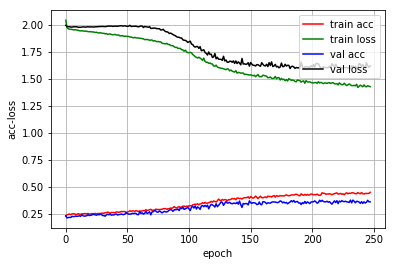

618/618 [==============================] - 0s 31us/step
test loss:  1.6245692937505283
test accuracy:  0.34304207129385866


In [25]:
history.loss_plot('epoch')
loss_4, accuracy_4 = model.evaluate(test_x, test_y)
print('test loss: ', loss_4)
print('test accuracy: ', accuracy_4)

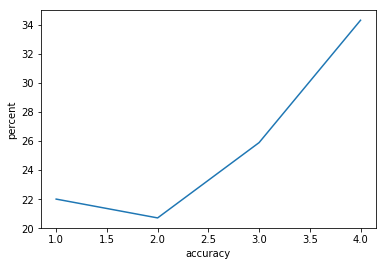

In [26]:
accuracy=[accuracy_1*100,accuracy_2*100,accuracy_3*100,accuracy_4*100]
number=[1,2,3,4]
plt.plot(number, accuracy)
plt.xlabel("accuracy")
plt.ylabel("percent")
plt.show()